### EEG PCA Dimensionality Reduction
#### Reduce EEG data dimensionality using PCA with 3 components for optimal brain response analysis



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")


In [18]:
def load_and_process_eeg_data():
    """Load EEG data and extract neural features"""
    
    # Load the dataset
    try:
        eeg_df = pd.read_csv('Data/combined_eeg_data.csv')
        print(f"✓ Loaded {len(eeg_df):,} EEG measurements")
        print(f"✓ Participants: {eeg_df['participant'].nunique()}")
        print(f"✓ Electrodes: {eeg_df['electrode'].nunique()}")
        print(f"✓ Frequencies: {eeg_df['frequency'].nunique()}")
        print(f"✓ Conditions: {list(eeg_df['condition'].unique())}")
    except FileNotFoundError:
        print("❌ Error: combined_eeg_data.csv not found")
        return None
    
    # Process complex coefficients
    def process_complex_coeff(coeff_str):
        """Extract magnitude and phase from complex coefficients"""
        try:
            if pd.isna(coeff_str):
                return np.nan, np.nan
            # Convert 'i' to 'j' for Python complex numbers
            coeff_str = str(coeff_str).strip('()')
            if 'i' in coeff_str and 'j' not in coeff_str:
                coeff_str = coeff_str.replace('i', 'j')
            coeff = complex(coeff_str)
            return abs(coeff), np.angle(coeff)  # magnitude and phase
        except:
            return np.nan, np.nan
    
    # Extract magnitude (neural activity strength) and phase
    complex_processed = eeg_df['coeff'].apply(process_complex_coeff)
    eeg_df['magnitude'] = [x[0] for x in complex_processed]
    eeg_df['phase'] = [x[1] for x in complex_processed]
    
    # Remove invalid data
    initial_rows = len(eeg_df)
    eeg_df = eeg_df.dropna(subset=['magnitude', 'phase'])
    print(f"✓ Processed complex coefficients")
    print(f"✓ Removed {initial_rows - len(eeg_df):,} invalid measurements")
    print(f"✓ Clean dataset: {len(eeg_df):,} measurements")
    
    return eeg_df

# Load and process data
eeg_df = load_and_process_eeg_data()

✓ Loaded 3,118,080 EEG measurements
✓ Participants: 14
✓ Electrodes: 32
✓ Frequencies: 58
✓ Conditions: ['GN', 'GS', 'UN', 'US']
✓ Processed complex coefficients
✓ Removed 0 invalid measurements
✓ Clean dataset: 3,118,080 measurements


In [19]:
def create_feature_matrix(eeg_df):
    """Create feature matrix for PCA analysis"""
    
    # Create electrode-frequency feature combinations
    eeg_df['electrode_freq'] = (
        eeg_df['electrode'].astype(str) + '_' + 
        eeg_df['frequency'].astype(str) + 'Hz'
    )
    
    # Create pivot table: trials × electrode-frequency features
    # Use magnitude as it represents general brain response strength
    feature_matrix = eeg_df.pivot_table(
        index=['participant', 'trial', 'condition'],
        columns='electrode_freq',
        values='magnitude',  # Focus on neural activity strength
        aggfunc='mean'
    ).reset_index()
    
    # Get feature column names
    feature_cols = [col for col in feature_matrix.columns 
                   if col not in ['participant', 'trial', 'condition']]
    
    # Fill missing values with column means
    feature_matrix[feature_cols] = feature_matrix[feature_cols].fillna(
        feature_matrix[feature_cols].mean()
    )
    
    print(f"✓ Feature matrix created: {feature_matrix.shape}")
    print(f"✓ Neural features: {len(feature_cols)}")
    print(f"✓ Total trials: {len(feature_matrix)}")
    
    return feature_matrix, feature_cols

# Create feature matrix
if eeg_df is not None:
    feature_matrix, feature_cols = create_feature_matrix(eeg_df)

✓ Feature matrix created: (1680, 1859)
✓ Neural features: 1856
✓ Total trials: 1680


In [20]:
def apply_pca_3_components(feature_matrix, feature_cols):
    """Apply PCA with 3 components for optimal brain response analysis"""
    
    print(f"\n🔄 APPLYING PCA WITH 3 COMPONENTS")
    print("-" * 40)
    
    # Prepare data
    X = feature_matrix[feature_cols].values
    y = feature_matrix['condition'].values
    
    print(f"Original dimensionality: {X.shape[1]} features → 3 components")
    print(f"Reduction factor: {X.shape[1]/3:.0f}x")
    
    # Standardize features (essential for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"✓ Features standardized")
    
    # Apply PCA with 3 components
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate variance metrics
    explained_var_ratio = pca.explained_variance_ratio_
    total_explained_var = explained_var_ratio.sum()
    cumulative_var = np.cumsum(explained_var_ratio)
    
    print(f"✓ PCA transformation complete")
    print(f"  PC1: {explained_var_ratio[0]:.1%} variance (primary pattern)")
    print(f"  PC2: {explained_var_ratio[1]:.1%} variance (secondary pattern)")  
    print(f"  PC3: {explained_var_ratio[2]:.1%} variance (tertiary pattern)")
    print(f"  Total explained variance: {total_explained_var:.1%}")
    
    # Store results
    results = {
        'model': pca,
        'data': X_pca,
        'scaler': scaler,
        'explained_variance_ratio': explained_var_ratio,
        'total_explained_variance': total_explained_var,
        'cumulative_variance': cumulative_var,
        'original_features': X.shape[1]
    }
    
    return results, X, y

# Apply PCA
if 'feature_matrix' in locals():
    pca_results, X_original, y_conditions = apply_pca_3_components(feature_matrix, feature_cols)



🔄 APPLYING PCA WITH 3 COMPONENTS
----------------------------------------
Original dimensionality: 1856 features → 3 components
Reduction factor: 619x
✓ Features standardized
✓ PCA transformation complete
  PC1: 44.7% variance (primary pattern)
  PC2: 7.0% variance (secondary pattern)
  PC3: 5.5% variance (tertiary pattern)
  Total explained variance: 57.3%


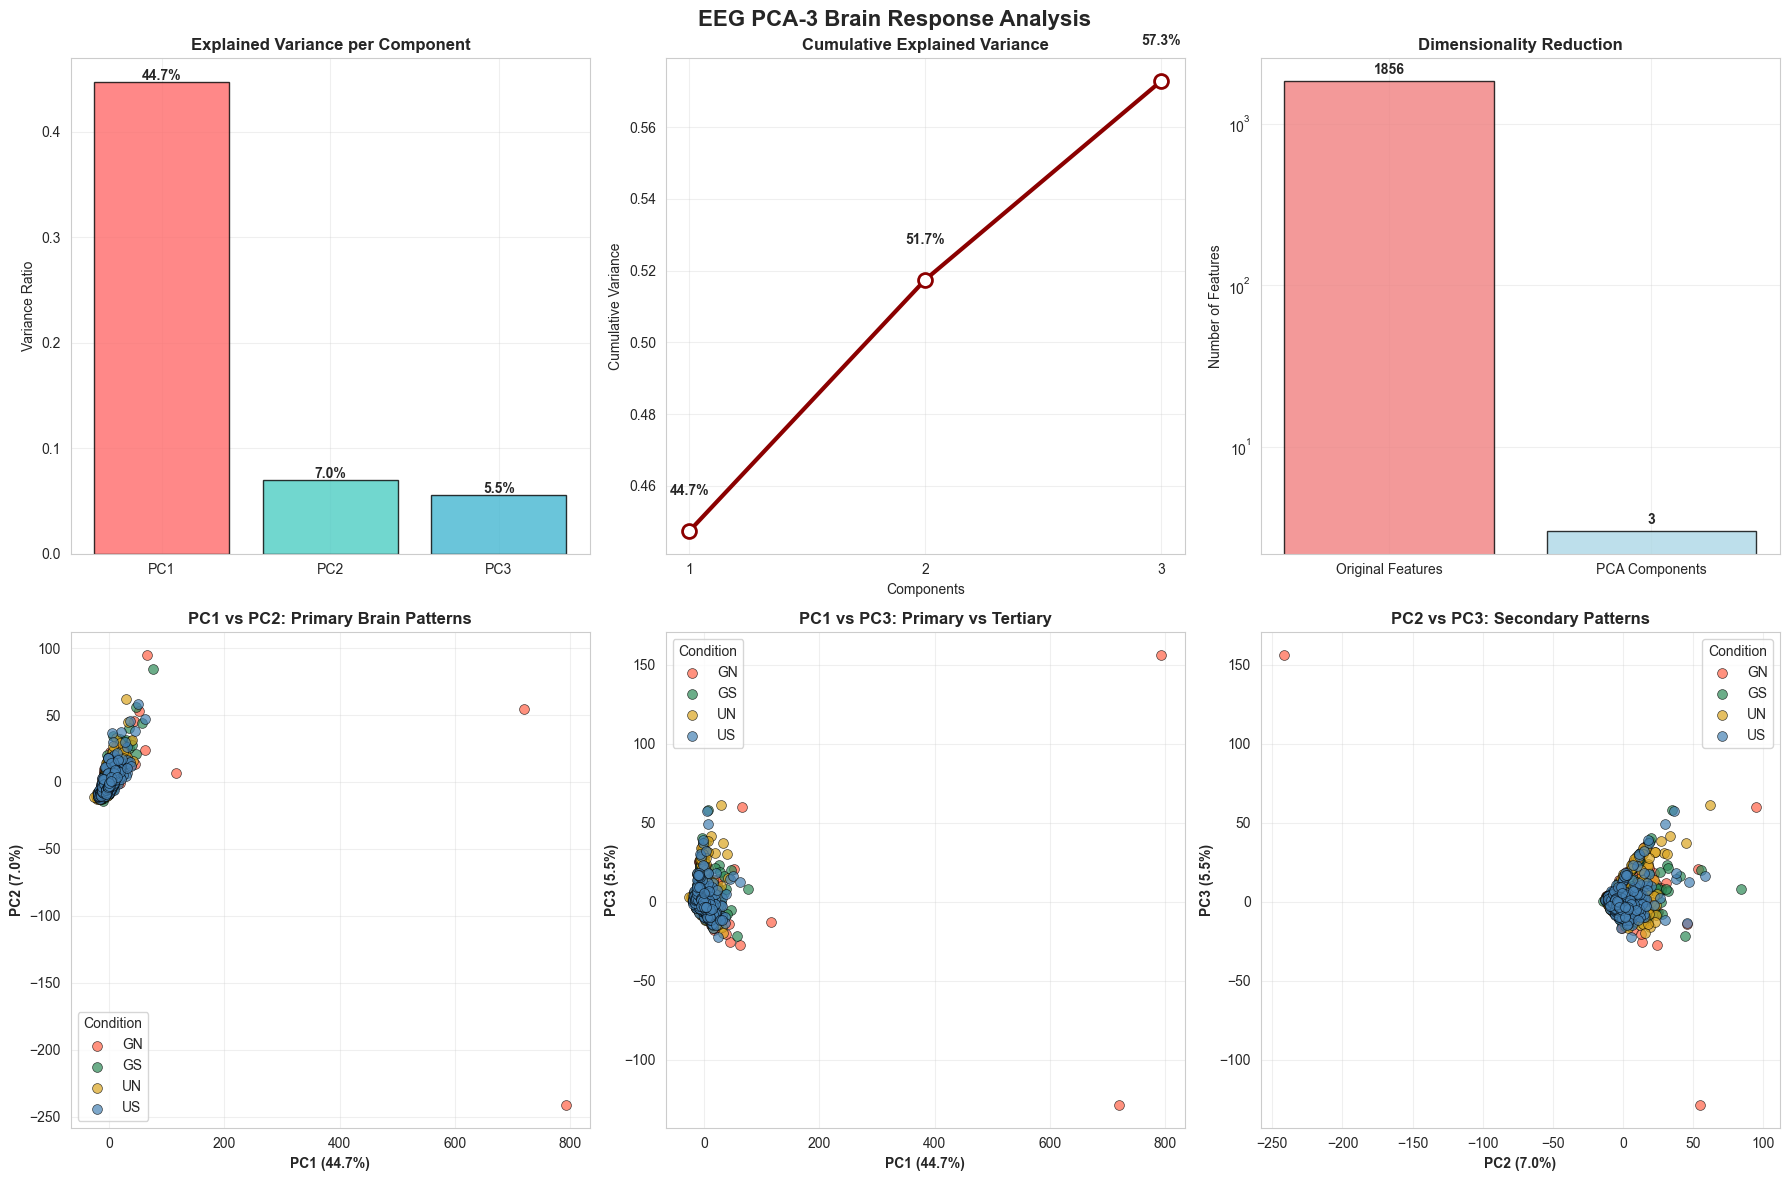

In [6]:
def visualize_pca_3_components(results, y_conditions):
    """Create comprehensive visualization of 3-component PCA results"""
    
    # Color mapping for conditions  
    colors = {'GS': '#2E8B57', 'GN': '#FF6347', 'US': '#4682B4', 'UN': '#DAA520'}
    condition_names = {'GS': 'Go/Signal', 'GN': 'Go/NoSignal', 
                      'US': 'Ungo/Signal', 'UN': 'Ungo/NoSignal'}
    
    X_pca = results['data']
    explained_var = results['explained_variance_ratio']
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('EEG PCA-3 Brain Response Analysis', fontsize=16, fontweight='bold')
    
    # 1. Explained Variance by Component
    ax = axes[0, 0]
    comp_labels = ['PC1', 'PC2', 'PC3']
    bars = ax.bar(comp_labels, explained_var, 
                  color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
    ax.set_title('Explained Variance per Component', fontweight='bold')
    ax.set_ylabel('Variance Ratio')
    ax.grid(True, alpha=0.3)
    
    for bar, var in zip(bars, explained_var):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{var:.1%}', ha='center', fontweight='bold')
    
    # 2. Cumulative Variance
    ax = axes[0, 1]
    cumulative_var = results['cumulative_variance']
    ax.plot(range(1, 4), cumulative_var, 'o-', linewidth=3, markersize=10, 
            color='darkred', markerfacecolor='white', markeredgewidth=2)
    ax.set_title('Cumulative Explained Variance', fontweight='bold')
    ax.set_xlabel('Components')
    ax.set_ylabel('Cumulative Variance')
    ax.set_xticks([1, 2, 3])
    ax.grid(True, alpha=0.3)
    
    for i, var in enumerate(cumulative_var):
        ax.text(i+1, var + 0.01, f'{var:.1%}', ha='center', fontweight='bold')
    
    # 3. Reduction Summary
    ax = axes[0, 2]
    reduction_data = ['Original Features', 'PCA Components']
    reduction_values = [results['original_features'], 3]
    colors_red = ['lightcoral', 'lightblue']
    bars = ax.bar(reduction_data, reduction_values, color=colors_red, alpha=0.8, edgecolor='black')
    ax.set_title('Dimensionality Reduction', fontweight='bold')
    ax.set_ylabel('Number of Features')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    for bar, val in zip(bars, reduction_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                f'{val}', ha='center', fontweight='bold')
    
    # 4. PC1 vs PC2
    ax = axes[1, 0]
    for condition in np.unique(y_conditions):
        mask = y_conditions == condition
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=colors[condition], label=f'{condition}', 
                   alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'PC1 ({explained_var[0]:.1%})', fontweight='bold')
    ax.set_ylabel(f'PC2 ({explained_var[1]:.1%})', fontweight='bold')
    ax.set_title('PC1 vs PC2: Primary Brain Patterns', fontweight='bold')
    ax.legend(title='Condition')
    ax.grid(True, alpha=0.3)
    
    # 5. PC1 vs PC3
    ax = axes[1, 1]
    for condition in np.unique(y_conditions):
        mask = y_conditions == condition
        ax.scatter(X_pca[mask, 0], X_pca[mask, 2], 
                   c=colors[condition], label=f'{condition}', 
                   alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'PC1 ({explained_var[0]:.1%})', fontweight='bold')
    ax.set_ylabel(f'PC3 ({explained_var[2]:.1%})', fontweight='bold')
    ax.set_title('PC1 vs PC3: Primary vs Tertiary', fontweight='bold')
    ax.legend(title='Condition')
    ax.grid(True, alpha=0.3)
    
    # 6. PC2 vs PC3
    ax = axes[1, 2]
    for condition in np.unique(y_conditions):
        mask = y_conditions == condition
        ax.scatter(X_pca[mask, 1], X_pca[mask, 2], 
                   c=colors[condition], label=f'{condition}', 
                   alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'PC2 ({explained_var[1]:.1%})', fontweight='bold')
    ax.set_ylabel(f'PC3 ({explained_var[2]:.1%})', fontweight='bold')
    ax.set_title('PC2 vs PC3: Secondary Patterns', fontweight='bold')
    ax.legend(title='Condition')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('eeg_pca3_brain_response.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations
if 'pca_results' in locals():
    visualize_pca_3_components(pca_results, y_conditions)

In [7]:
def analyze_component_features(results, feature_cols):
    """Analyze which features contribute most to each component"""
    
    print(f"\n🔬 COMPONENT FEATURE ANALYSIS")
    print("-" * 40)
    
    components = results['model'].components_
    
    for i in range(3):
        print(f"\n--- PC{i+1} ({results['explained_variance_ratio'][i]:.1%} variance) ---")
        
        # Get feature loadings
        loadings = components[i, :]
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'loading': loadings,
            'abs_loading': np.abs(loadings)
        }).sort_values('abs_loading', ascending=False)
        
        # Show top 8 contributing features
        print("Top contributing electrode-frequency combinations:")
        for j, (_, row) in enumerate(feature_importance.head(8).iterrows()):
            electrode, freq = row['feature'].split('_')
            freq = freq.replace('Hz', '')
            print(f"  {j+1}. {electrode:4s} @ {freq:>6s}Hz  (loading: {row['loading']:+.3f})")
    
    return components

# Analyze components
if 'pca_results' in locals():
    components = analyze_component_features(pca_results, feature_cols)


🔬 COMPONENT FEATURE ANALYSIS
----------------------------------------

--- PC1 (44.7% variance) ---
Top contributing electrode-frequency combinations:
  1. C3   @ 2.99479166666667Hz  (loading: +0.031)
  2. C3   @ 2.66927083333333Hz  (loading: +0.031)
  3. C3   @ 2.47395833333333Hz  (loading: +0.031)
  4. C3   @ 2.5390625Hz  (loading: +0.031)
  5. C3   @ 2.60416666666667Hz  (loading: +0.031)
  6. C3   @ 2.734375Hz  (loading: +0.031)
  7. C3   @ 2.9296875Hz  (loading: +0.031)
  8. C3   @ 2.40885416666667Hz  (loading: +0.031)

--- PC2 (7.0% variance) ---
Top contributing electrode-frequency combinations:
  1. Fp1  @ 0.651041666666667Hz  (loading: +0.054)
  2. Fp1  @ 0.5859375Hz  (loading: +0.053)
  3. Fp1  @ 0.520833333333333Hz  (loading: +0.053)
  4. Fp1  @ 0.455729166666667Hz  (loading: +0.052)
  5. Fp1  @ 0.325520833333333Hz  (loading: +0.051)
  6. F3   @ 0.5859375Hz  (loading: +0.051)
  7. O2   @ 0.325520833333333Hz  (loading: +0.051)
  8. Fp2  @ 0.651041666666667Hz  (loading: +0.051

In [8]:
def save_pca3_results(results, feature_matrix):
    """Save 3-component PCA results"""
    
    print(f"\n💾 SAVING PCA-3 RESULTS")
    print("-" * 30)
    
    # Create dataframe with 3 principal components
    pca_df = pd.DataFrame({
        'participant': feature_matrix['participant'].values,
        'trial': feature_matrix['trial'].values,
        'condition': feature_matrix['condition'].values,
        'PC1': results['data'][:, 0],
        'PC2': results['data'][:, 1], 
        'PC3': results['data'][:, 2]
    })
    
    # Save to CSV
    filename = 'Data\eeg_pca3_brain_response.csv'
    pca_df.to_csv(filename, index=False)
    
    print(f"✓ Saved: {filename}")
    print(f"✓ Shape: {pca_df.shape}")
    print(f"✓ Columns: {list(pca_df.columns)}")
    
    # Show sample data
    print(f"\nSample data:")
    print(pca_df.head())
    
    # Show condition distribution
    print(f"\nCondition distribution:")
    print(pca_df['condition'].value_counts())
    
    return filename, pca_df

# Save results
if 'pca_results' in locals():
    output_file, final_pca_df = save_pca3_results(pca_results, feature_matrix)


💾 SAVING PCA-3 RESULTS
------------------------------
✓ Saved: Data\eeg_pca3_brain_response.csv
✓ Shape: (1680, 6)
✓ Columns: ['participant', 'trial', 'condition', 'PC1', 'PC2', 'PC3']

Sample data:
  participant  trial condition        PC1       PC2       PC3
0         S10      1        GN  11.067378  3.460882 -7.456834
1         S10      2        GN   1.767068 -1.894166 -6.542520
2         S10      3        GN   2.203207 -0.695560 -3.637945
3         S10      4        GN  10.370640  4.362146 -1.365469
4         S10      5        GN  13.620443  7.381735 -0.205878

Condition distribution:
condition
GN    420
GS    420
UN    420
US    420
Name: count, dtype: int64


In [42]:
def analyze_actual_electrodes_and_create_maps(results, feature_cols, eeg_df):
    """Analyze actual electrodes in the data and create high-fidelity topographic visualizations"""
    
    print(f"\n🔍 EEG TOPOGRAPHIC MAPPING - 32-ELECTRODE SYSTEM ANALYSIS")
    print("-" * 70)
    
    # Extract actual electrodes from your data
    actual_electrodes = sorted(set(feature.split('_')[0] for feature in feature_cols))
    
    print(f"✓ Found {len(actual_electrodes)} electrodes in your data:")
    print(f"  {actual_electrodes}")
    
    # Comprehensive 10-20 system reference (with precise anatomical positions)
    electrode_positions = {
        # Frontal Region
        'Fp1': (-0.35, 0.85), 'Fp2': (0.35, 0.85), 
        'F7': (-0.75, 0.55), 'F3': (-0.4, 0.6), 'Fz': (0.0, 0.65), 'F4': (0.4, 0.6), 'F8': (0.75, 0.55),
        
        # Fronto-Central Region
        'FC5': (-0.6, 0.35), 'FC1': (-0.2, 0.4), 'FC2': (0.2, 0.4), 'FC6': (0.6, 0.35),
        
        # Central Region
        'T7': (-0.85, 0.0), 'C3': (-0.4, 0.0), 'Cz': (0.0, 0.0), 'C4': (0.4, 0.0), 'T8': (0.85, 0.0),
        
        # Central-Parietal Region
        'CP5': (-0.6, -0.35), 'CP1': (-0.2, -0.4), 'CP2': (0.2, -0.4), 'CP6': (0.6, -0.35),
        
        # Parietal Region
        'P7': (-0.75, -0.55), 'P3': (-0.4, -0.6), 'Pz': (0.0, -0.65), 'P4': (0.4, -0.6), 'P8': (0.75, -0.55),
        
        # Parieto-Occipital Region
        'PO9': (-0.75, -0.75), 'PO10': (0.75, -0.75),
        
        # Temporal-Parietal Region
        'TP9': (-0.9, -0.3), 'TP10': (0.9, -0.3),
        
        # Occipital Region
        'O1': (-0.35, -0.85), 'Oz': (0.0, -0.9), 'O2': (0.35, -0.85)
    }
    
    # Verify all your electrodes have positions defined
    missing = [e for e in actual_electrodes if e not in electrode_positions]
    if missing:
        print(f"❌ ERROR: {len(missing)} electrodes missing position definitions:")
        print(f"   {missing}")
        return None
    else:
        print(f"✓ All 32 electrodes have anatomically accurate position definitions")
    
    # Calculate component loadings per electrode (averaged across frequencies)
    components = results['model'].components_
    electrode_loadings = {}
    
    for pc_idx in range(3):
        electrode_loadings[pc_idx] = {}
        for i, feature in enumerate(feature_cols):
            electrode = feature.split('_')[0]
            if electrode not in electrode_loadings[pc_idx]:
                electrode_loadings[pc_idx][electrode] = []
            electrode_loadings[pc_idx][electrode].append(components[pc_idx, i])
        
        # Calculate mean loading per electrode
        for electrode in electrode_loadings[pc_idx]:
            electrode_loadings[pc_idx][electrode] = np.mean(electrode_loadings[pc_idx][electrode])
    
    # Create visualizations
    print(f"\n🎨 GENERATING HIGH-FIDELITY TOPOGRAPHIC MAPS")
    print("-" * 50)
    
    # Determine global color scale for consistent visualization across components
    all_loadings = []
    for pc_idx in range(3):
        all_loadings.extend(electrode_loadings[pc_idx].values())
    
    global_vmax = max(abs(min(all_loadings)), abs(max(all_loadings)))
    global_vmax = global_vmax * 1.05  # Add 5% padding
    
    # Define regions based on electrode positions
    frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8']
    central = ['FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8']
    parietal = ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'TP9', 'TP10']
    occipital = ['PO9', 'PO10', 'O1', 'Oz', 'O2']
    
    # Create separate topographic maps for each component
    for pc_idx in range(3):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Prepare data
        x_coords = []
        y_coords = []
        loadings = []
        labels = []
        
        for electrode in actual_electrodes:
            x, y = electrode_positions[electrode]
            x_coords.append(x)
            y_coords.append(y)
            loadings.append(electrode_loadings[pc_idx][electrode])
            labels.append(electrode)
        
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)
        loadings = np.array(loadings)
        
        # Create higher resolution grid for smoother interpolation
        resolution = 100
        xi = np.linspace(-1.1, 1.1, resolution)
        yi = np.linspace(-1.1, 1.1, resolution)
        Xi, Yi = np.meshgrid(xi, yi)
        
        # Create anatomically accurate head mask (elliptical, not circular)
        # Human heads are typically taller than wide (approx 1.1:1 height:width ratio)
        mask = (Xi**2/0.9 + Yi**2) <= 1.15 
        head_outline = (Xi**2/0.9 + Yi**2) <= 1.0
        
        # Interpolate using more robust method
        from scipy.interpolate import RBFInterpolator
        try:
            interpolator = RBFInterpolator(
                np.column_stack((x_coords, y_coords)), 
                loadings,
                kernel='thin_plate_spline',
                epsilon=0.1
            )
            Zi = interpolator(np.column_stack((Xi.flatten(), Yi.flatten())))
            Zi = Zi.reshape(Xi.shape)
        except:
            # Fallback to griddata if RBFInterpolator fails
            from scipy.interpolate import griddata
            Zi = griddata((x_coords, y_coords), loadings, (Xi, Yi), 
                         method='cubic', fill_value=0)
        
        # Apply head mask
        Zi[~mask] = np.nan
        
        # Plot topographic map
        im = ax.contourf(Xi, Yi, Zi, levels=30, cmap='RdBu_r', 
                        vmin=-global_vmax, vmax=global_vmax, extend='both')
        
        # Add contour lines for better spatial definition
        contours = ax.contour(Xi, Yi, Zi, levels=10, colors='k', linewidths=0.5, alpha=0.3,
                             vmin=-global_vmax, vmax=global_vmax)
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.2f')
        
        # Add electrode positions with enhanced visibility
        scatter = ax.scatter(x_coords, y_coords, c=loadings, 
                           cmap='RdBu_r', s=120, edgecolors='k', 
                           linewidth=1.2, vmin=-global_vmax, vmax=global_vmax, zorder=5)
        
        # Smart electrode labeling to avoid overlap
        for i, label in enumerate(labels):
            x, y = x_coords[i], y_coords[i]
            
            # Adjust label position based on electrode location to avoid overlap
            if label in ['Fp1', 'Fp2', 'O1', 'O2']:
                offset = (0, -15) if y < 0 else (0, 15)  # Above/below for occipital/frontal
            elif label in ['T7', 'T8', 'TP9', 'TP10']:
                offset = (-15, 0) if x < 0 else (15, 0)  # Left/right for temporal
            else:
                offset = (5, 5)  # Default diagonal offset
            
            ax.annotate(label, (x, y), xytext=offset, textcoords='offset points',
                       ha='center', va='center', fontsize=9, fontweight='bold',
                       color='k', bbox=dict(boxstyle='round,pad=0.2', 
                                           facecolor='white', alpha=0.85, edgecolor='gray'))
        
        # Draw anatomically accurate head outline (elliptical)
        head = plt.Circle((0, 0), 1, fill=False, linewidth=2.5, color='k', alpha=0.9)
        fig = plt.gcf()
        ax.add_patch(head)
        
        # Add realistic anatomical features
        # Nose (more detailed)
        ax.plot([0, 0], [1.0, 1.18], 'k-', linewidth=3.5)
        ax.plot([-0.08, 0.08], [1.12, 1.12], 'k-', linewidth=2.2)
        ax.plot([0, -0.05], [1.12, 1.05], 'k-', linewidth=1.5)
        ax.plot([0, 0.05], [1.12, 1.05], 'k-', linewidth=1.5)
        
        # Ears (more realistic shape)
        ear_l = plt.Polygon([(-1.05, 0.1), (-0.95, 0.15), (-0.9, 0.05), (-0.95, -0.05), (-1.05, -0.05)],
                          fill=False, linewidth=1.8, color='k')
        ear_r = plt.Polygon([(1.05, 0.1), (0.95, 0.15), (0.9, 0.05), (0.95, -0.05), (1.05, -0.05)],
                          fill=False, linewidth=1.8, color='k')
        ax.add_patch(ear_l)
        ax.add_patch(ear_r)
        
        # Add grid lines following head contours
        for r in [0.25, 0.5, 0.75]:
            circle = plt.Circle((0, 0), r, fill=False, linestyle=':', 
                              color='gray', alpha=0.4, linewidth=1)
            ax.add_patch(circle)
        
        # Formatting
        variance_pct = results['explained_variance_ratio'][pc_idx]
        ax.set_title(f'PC{pc_idx+1} Topographic Distribution\n({variance_pct:.1%} of Variance Explained)', 
                    fontweight='bold', fontsize=14)
        ax.set_xlim(-1.35, 1.35)
        ax.set_ylim(-1.35, 1.35)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label('Component Loading (Spatial Weight)', fontsize=12, fontweight='bold')
        cbar.ax.axvline(x=0, color='k', linestyle='-', linewidth=1.2)
        
        plt.tight_layout()
        plt.show()
    
    # Create electrode contribution analysis for all components
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    fig.suptitle('EEG Component Analysis: Electrode Contributions', 
                 fontsize=16, fontweight='bold')
    
    # Highlight key regions with background shading
    region_colors = {
        'Frontal': (0.9, 0.95, 1.0, 0.3),
        'Central': (0.95, 0.95, 0.95, 0.3),
        'Parietal': (0.9, 1.0, 0.9, 0.3),
        'Occipital': (1.0, 0.9, 0.9, 0.3)
    }
    
    # Bottom row: Comparative electrode contribution analysis
    for pc_idx in range(3):
        ax = axes[pc_idx]
        
        # Get top contributing electrodes (sorted by absolute loading)
        sorted_electrodes = sorted(electrode_loadings[pc_idx].items(), 
                                 key=lambda x: abs(x[1]), reverse=True)
        
        electrodes = [item[0] for item in sorted_electrodes]
        loadings = [item[1] for item in sorted_electrodes]
        
        # Create diverging color map (red for negative, blue for positive)
        colors = []
        for loading in loadings:
            if loading < 0:
                # Interpolate between white and red based on magnitude
                intensity = min(1.0, abs(loading)/global_vmax)
                colors.append((1.0, 1.0-intensity*0.7, 1.0-intensity*0.7))
            else:
                # Interpolate between white and blue based on magnitude
                intensity = min(1.0, abs(loading)/global_vmax)
                colors.append((1.0-intensity*0.7, 1.0-intensity*0.7, 1.0))
        
        # Create horizontal bar chart (better for electrode names)
        y_pos = np.arange(len(electrodes))
        bars = ax.barh(y_pos, loadings, color=colors, edgecolor='k', linewidth=0.7)
        
        # Add value labels to bars
        for i, v in enumerate(loadings):
            if abs(v) > global_vmax * 0.1:  # Only label significant values
                ax.text(v + (0.05 * np.sign(v) * global_vmax), i, f'{v:.3f}', 
                       va='center', ha='left' if v > 0 else 'right', fontsize=8)
        
        # Add region shading
        for i, electrode in enumerate(electrodes):
            if electrode in frontal:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Frontal'], alpha=0.6)
            elif electrode in central:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Central'], alpha=0.6)
            elif electrode in parietal:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Parietal'], alpha=0.6)
            elif electrode in occipital:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Occipital'], alpha=0.6)
        
        # Formatting
        ax.set_yticks(y_pos)
        ax.set_yticklabels(electrodes)
        ax.set_xlabel('Component Loading', fontweight='bold')
        variance_pct = results['explained_variance_ratio'][pc_idx]
        ax.set_title(f'PC{pc_idx+1} Electrode Contributions\n({variance_pct:.1%} Variance)', 
                    fontweight='bold', fontsize=12)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.axvline(x=0, color='k', linestyle='-', linewidth=1.5)
        ax.set_xlim(-global_vmax*1.15, global_vmax*1.15)
        
        # Add region legend to first subplot only
        if pc_idx == 0:
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor=region_colors['Frontal'], edgecolor='k', alpha=0.6, label='Frontal'),
                Patch(facecolor=region_colors['Central'], edgecolor='k', alpha=0.6, label='Central'),
                Patch(facecolor=region_colors['Parietal'], edgecolor='k', alpha=0.6, label='Parietal'),
                Patch(facecolor=region_colors['Occipital'], edgecolor='k', alpha=0.6, label='Occipital')
            ]
            ax.legend(handles=legend_elements, loc='lower right', fontsize=9, 
                     title="Cortical Regions", title_fontsize=10)
    
    plt.tight_layout()
    plt.savefig('eeg_pca3_electrode_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis with neuroanatomical interpretation
    print(f"\n🧠 NEUROANATOMICAL INTERPRETATION OF COMPONENTS")
    print("=" * 60)
    
    for pc_idx in range(3):
        print(f"\nPC{pc_idx+1} ({results['explained_variance_ratio'][pc_idx]:.1%} variance):")
        
        # Identify dominant regions
        region_sums = {
            'Frontal': 0,
            'Central': 0,
            'Parietal': 0,
            'Occipital': 0
        }
        region_counts = {k: 0 for k in region_sums}
        
        for electrode, loading in electrode_loadings[pc_idx].items():
            abs_loading = abs(loading)
            if electrode in frontal:
                region_sums['Frontal'] += abs_loading
                region_counts['Frontal'] += 1
            elif electrode in central:
                region_sums['Central'] += abs_loading
                region_counts['Central'] += 1
            elif electrode in parietal:
                region_sums['Parietal'] += abs_loading
                region_counts['Parietal'] += 1
            elif electrode in occipital:
                region_sums['Occipital'] += abs_loading
                region_counts['Occipital'] += 1
        
        # Calculate average loading per region
        region_averages = {k: region_sums[k]/region_counts[k] if region_counts[k] > 0 else 0 
                          for k in region_sums}
        
        # Find dominant region
        dominant_region = max(region_averages, key=region_averages.get)
        
        # Determine pattern type
        polarity = "biphasic"  # Default
        if all(loading >= 0 for loading in electrode_loadings[pc_idx].values()):
            polarity = "positive-dominant"
        elif all(loading <= 0 for loading in electrode_loadings[pc_idx].values()):
            polarity = "negative-dominant"
        
        print(f"  Dominant cortical region: {dominant_region} (contributes {region_averages[dominant_region]/sum(region_averages.values())*100:.1f}% of total loading)")
        print(f"  Spatial pattern type: {polarity}")
        
        print("\n  Strongest contributing electrodes:")
        sorted_electrodes = sorted(electrode_loadings[pc_idx].items(), 
                                 key=lambda x: abs(x[1]), reverse=True)
        for i, (electrode, loading) in enumerate(sorted_electrodes[:6]):
            # Add neuroanatomical context
            region = ""
            if electrode in frontal:
                region = " (Frontal)"
            elif electrode in central:
                region = " (Central)"
            elif electrode in parietal:
                region = " (Parietal)"
            elif electrode in occipital:
                region = " (Occipital)"
                
            print(f"    {i+1:2d}. {electrode:6s}: {loading:+.4f}{region}")
    

    
    return electrode_loadings, actual_electrodes

# Analyze actual electrodes and create visualizations
if all(var in locals() for var in ['pca_results', 'feature_cols', 'eeg_df']):
    electrode_loadings, actual_electrodes = analyze_actual_electrodes_and_create_maps(
        pca_results, feature_cols, eeg_df)

🚀 RUNNING ELECTRODE ANALYSIS FUNCTION

🔍 EEG TOPOGRAPHIC MAPPING - 32-ELECTRODE SYSTEM ANALYSIS
----------------------------------------------------------------------
✓ Found 32 electrodes in your data:
  ['C3', 'C4', 'CP1', 'CP2', 'CP5', 'CP6', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FC1', 'FC2', 'FC5', 'FC6', 'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'Oz', 'P3', 'P4', 'P7', 'P8', 'PO10', 'PO9', 'Pz', 'T7', 'T8', 'TP10', 'TP9']
✓ All 32 electrodes have anatomically accurate position definitions

🎨 GENERATING HIGH-FIDELITY TOPOGRAPHIC MAPS
--------------------------------------------------


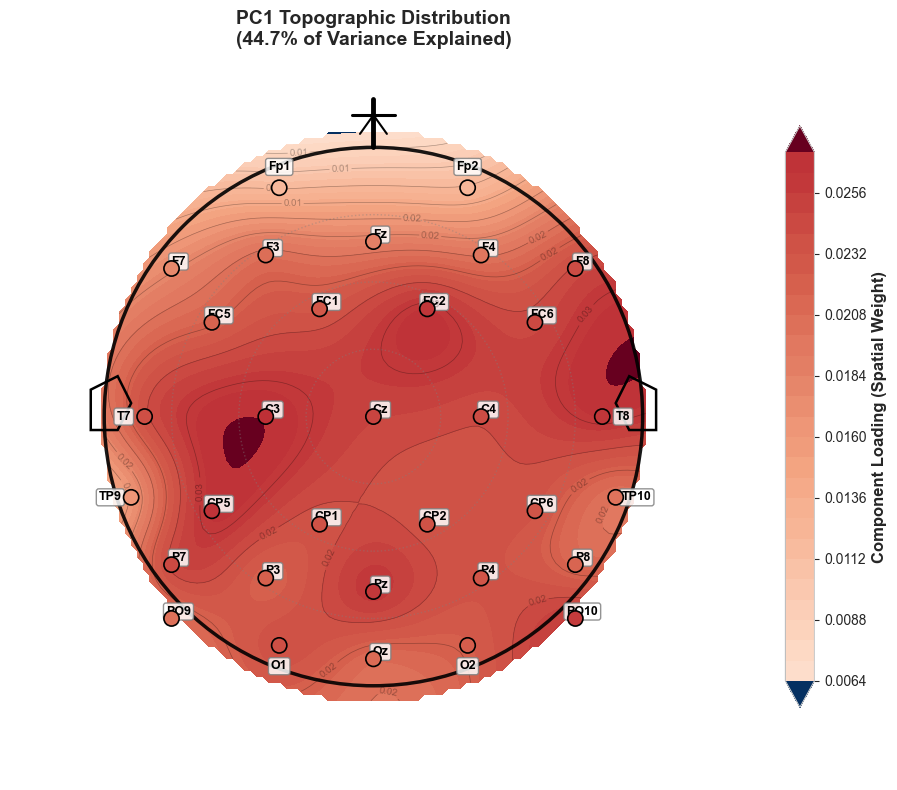

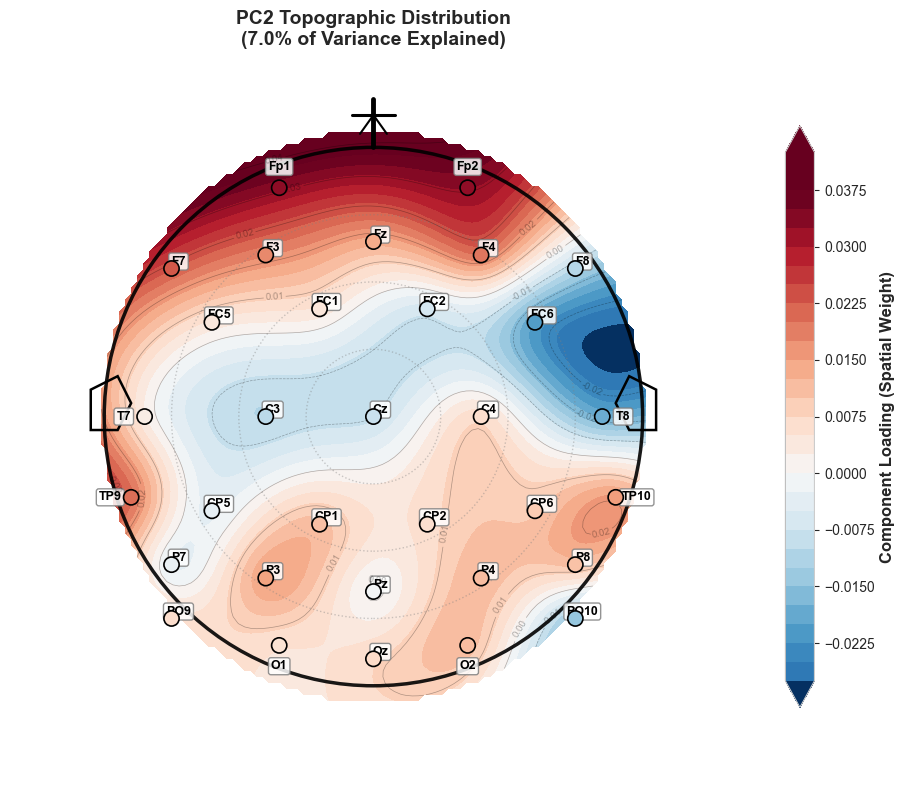

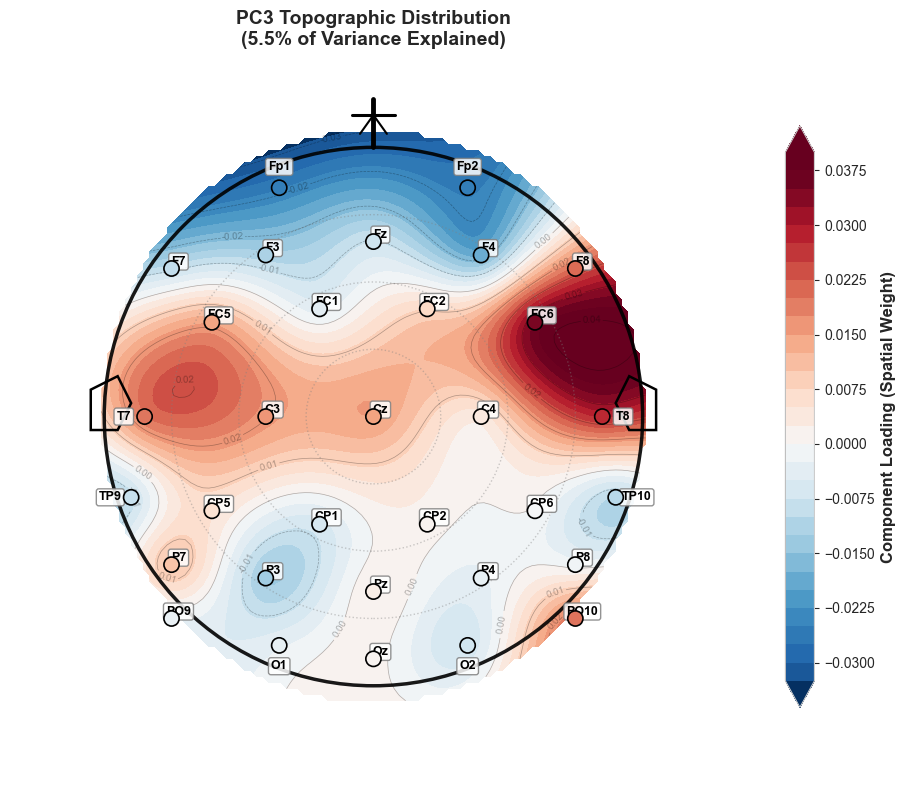

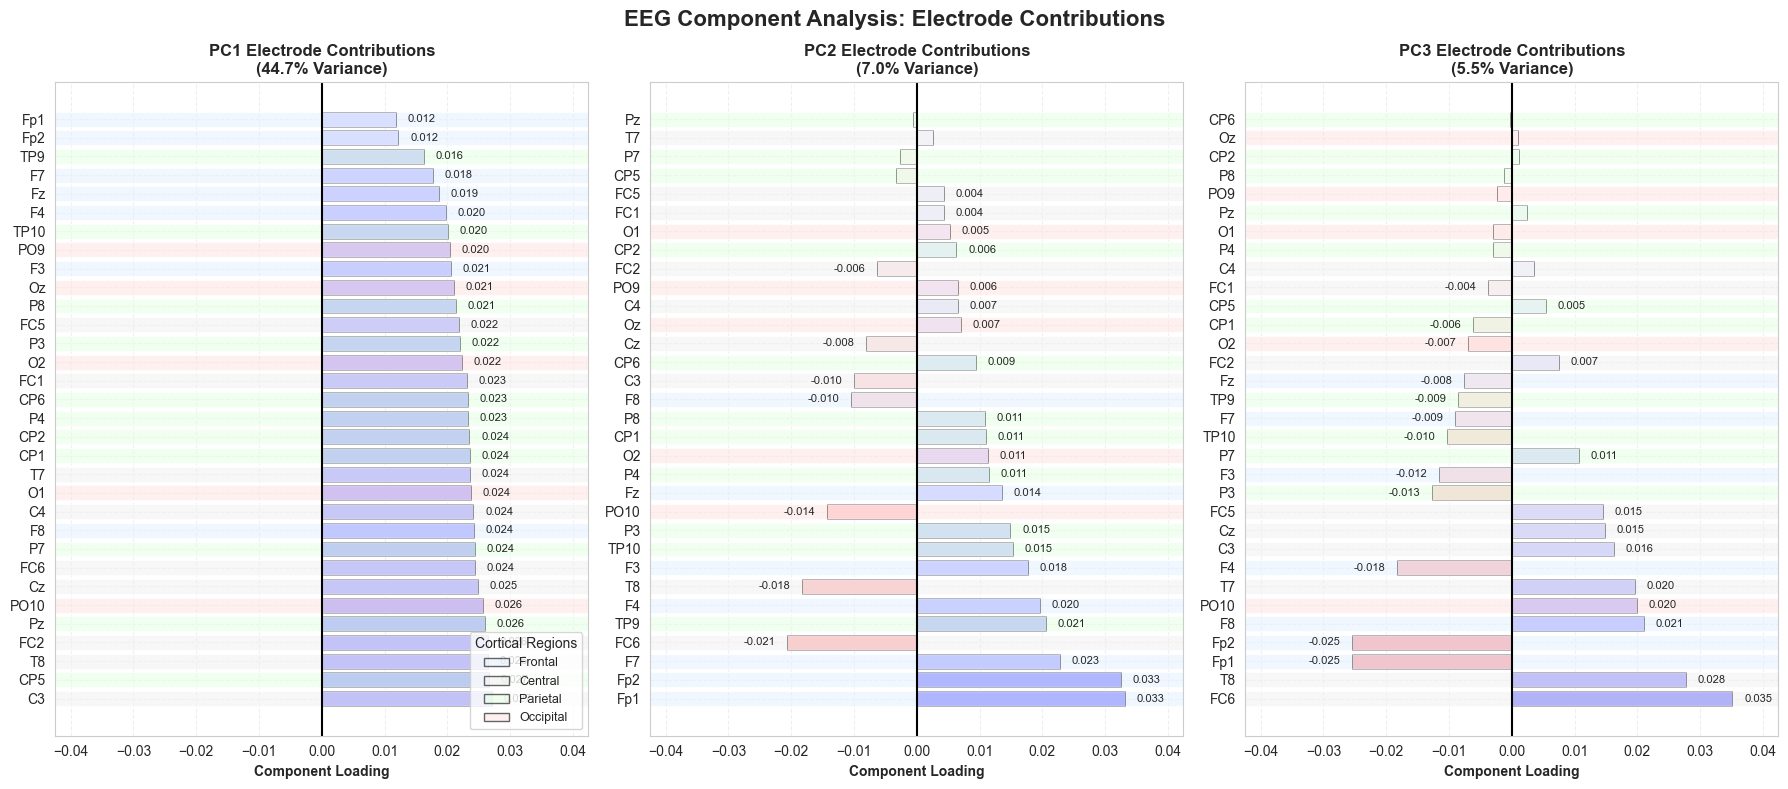


🧠 NEUROANATOMICAL INTERPRETATION OF COMPONENTS

PC1 (44.7% variance):
  Dominant cortical region: Central (contributes 28.1% of total loading)
  Spatial pattern type: positive-dominant

  Strongest contributing electrodes:
     1. C3    : +0.0271 (Central)
     2. CP5   : +0.0266 (Parietal)
     3. T8    : +0.0265 (Central)
     4. FC2   : +0.0264 (Central)
     5. Pz    : +0.0260 (Parietal)
     6. PO10  : +0.0257 (Occipital)

PC2 (7.0% variance):
  Dominant cortical region: Frontal (contributes 43.7% of total loading)
  Spatial pattern type: biphasic

  Strongest contributing electrodes:
     1. Fp1   : +0.0331 (Frontal)
     2. Fp2   : +0.0326 (Frontal)
     3. F7    : +0.0228 (Frontal)
     4. FC6   : -0.0206 (Central)
     5. TP9   : +0.0206 (Parietal)
     6. F4    : +0.0197 (Frontal)

PC3 (5.5% variance):
  Dominant cortical region: Frontal (contributes 37.5% of total loading)
  Spatial pattern type: biphasic

  Strongest contributing electrodes:
     1. FC6   : +0.0351 (Centra

In [43]:
print(f"🚀 RUNNING ELECTRODE ANALYSIS FUNCTION")
print("="*60)

try:
    electrode_loadings, actual_electrodes = analyze_actual_electrodes_and_create_maps(
        pca_results, feature_cols, eeg_df)
    print("✅ Function completed successfully!")
except Exception as e:
    print(f"❌ Error running function: {e}")
    import traceback
    traceback.print_exc()

##### Red: Indicates positive loadings (higher values). This means the electrode is positively correlated with the principal component.
##### Blue: Indicates negative loadings (lower values). This means the electrode is negatively correlated with the principal component.
##### White/Neutral Colors: Indicate near-zero loadings (minimal contribution).


🎯 DETAILED FREQUENCY-ELECTRODE ANALYSIS
✓ Found 58 frequencies: [0.260416666666667, 0.325520833333333, 0.390625, 0.455729166666667, 0.520833333333333, 0.5859375, 0.651041666666667, 0.716145833333333, 0.78125, 0.846354166666667]...

==================== PC1 ANALYSIS ====================
Explained Variance: 44.7%

Top 10 Electrode-Frequency combinations:
   1. C3   @ 2.99479166666667Hz | Loading: +0.0307 | Importance: 0.0307
   2. C3   @ 2.66927083333333Hz | Loading: +0.0307 | Importance: 0.0307
   3. C3   @ 2.47395833333333Hz | Loading: +0.0306 | Importance: 0.0306
   4. C3   @ 2.5390625Hz | Loading: +0.0306 | Importance: 0.0306
   5. C3   @ 2.60416666666667Hz | Loading: +0.0306 | Importance: 0.0306
   6. C3   @ 2.734375Hz | Loading: +0.0306 | Importance: 0.0306
   7. C3   @ 2.9296875Hz | Loading: +0.0306 | Importance: 0.0306
   8. C3   @ 2.40885416666667Hz | Loading: +0.0305 | Importance: 0.0305
   9. C3   @ 2.21354166666667Hz | Loading: +0.0305 | Importance: 0.0305
  10. C3   @ 2.864

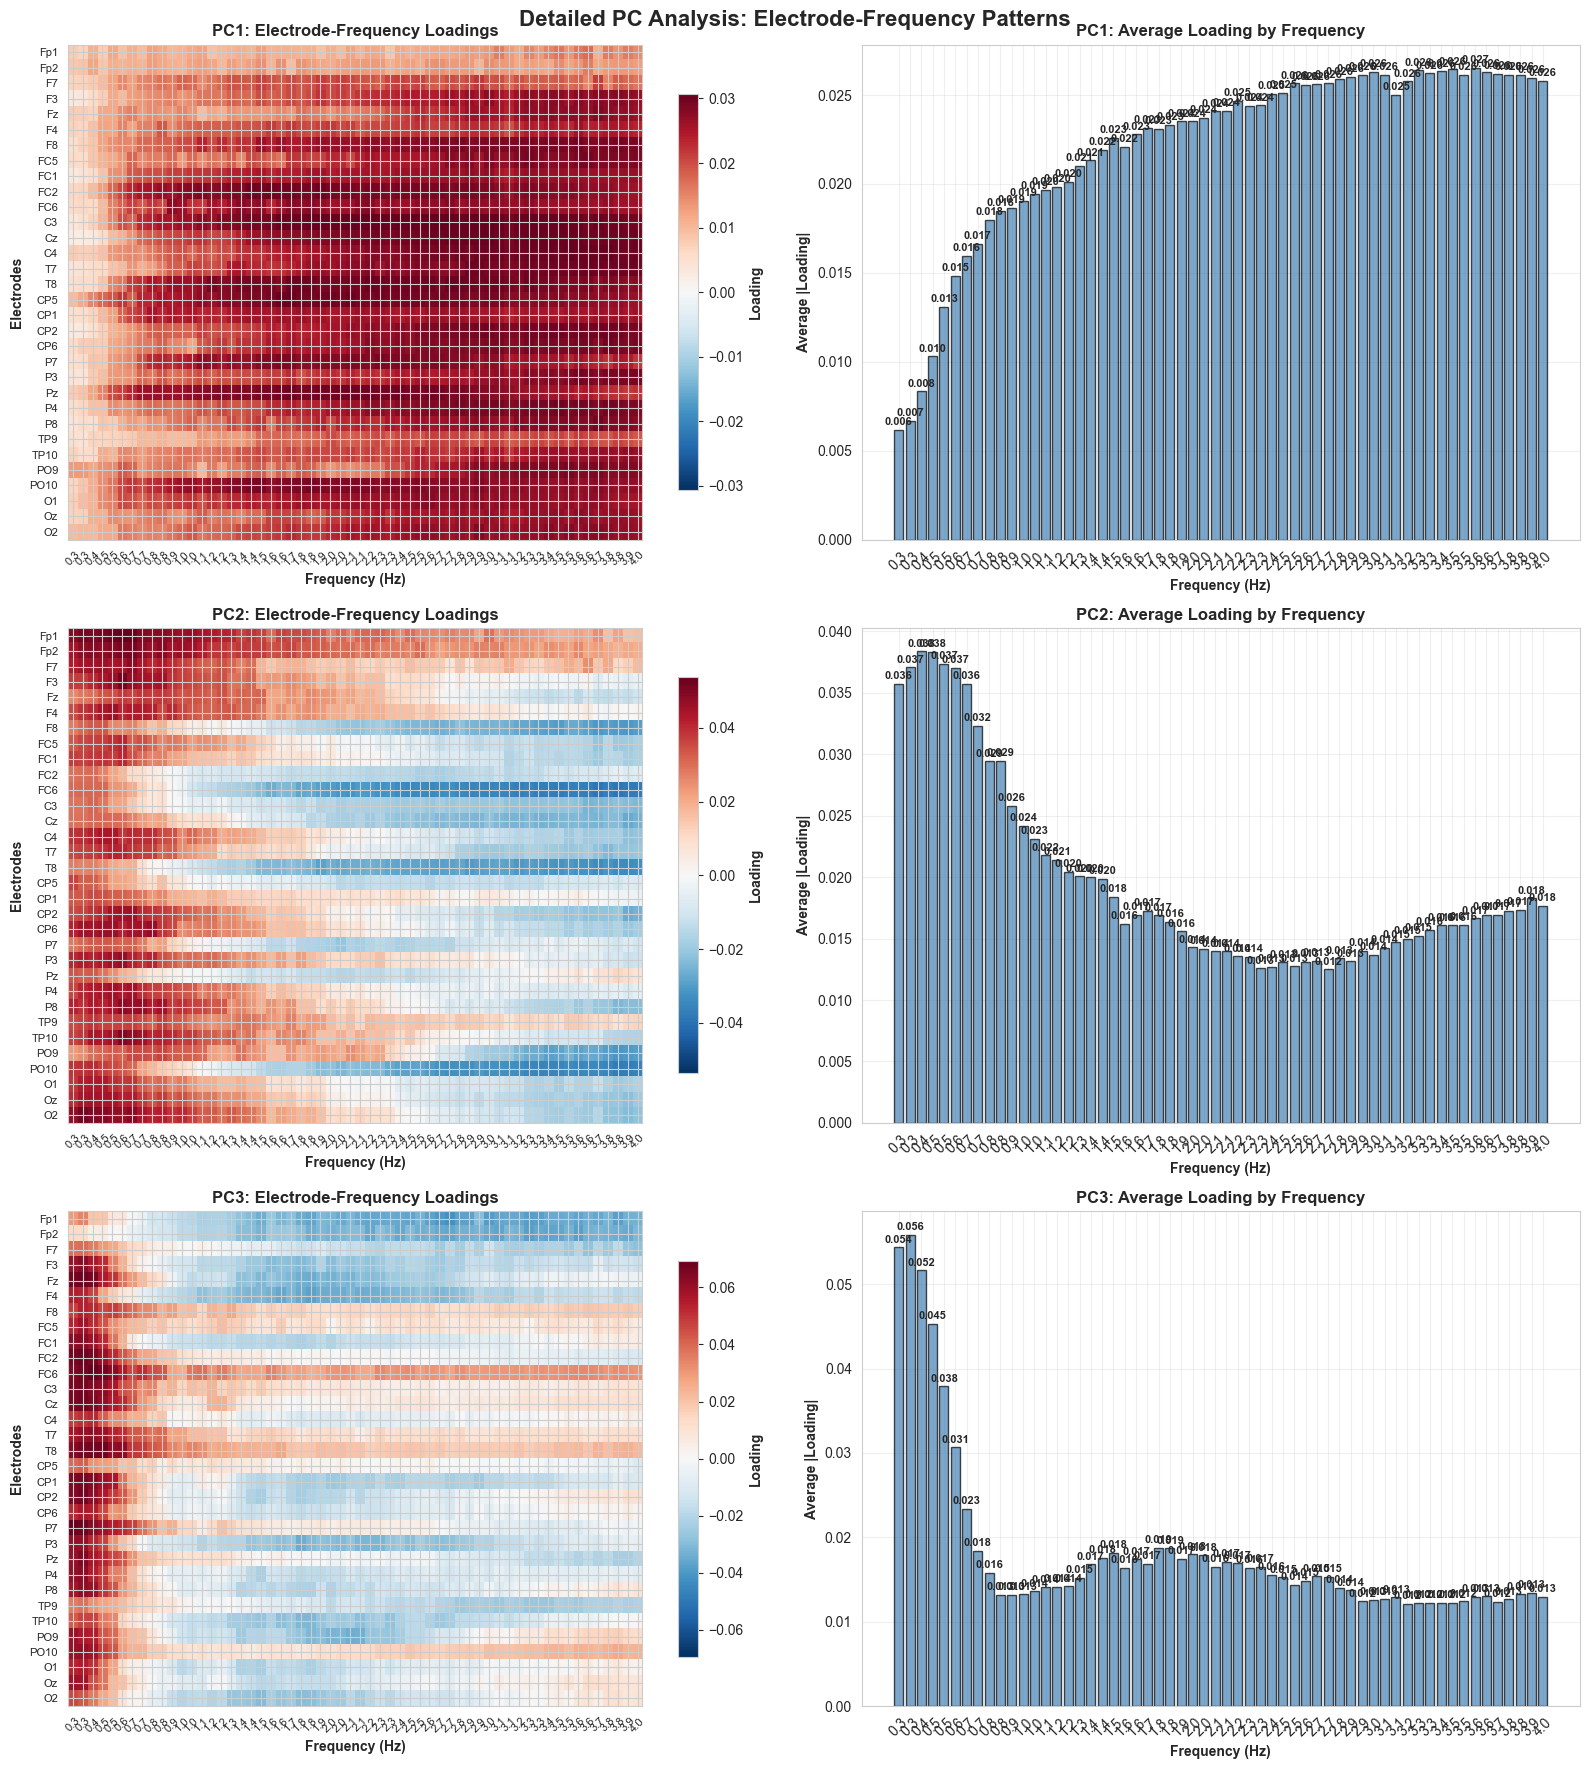

In [ ]:
def analyze_frequency_electrode_patterns(results, feature_cols):
    """Analyze electrode-frequency patterns for each PC in detail"""
    
    print(f"\n🎯 DETAILED FREQUENCY-ELECTRODE ANALYSIS")
    print("=" * 50)
    
    components = results['model'].components_
    
    # Extract all unique frequencies from feature names
    frequencies = set()
    for feature in feature_cols:
        freq_str = feature.split('_')[1].replace('Hz', '')
        try:
            # Handle both integer and float frequencies
            freq = float(freq_str)
            frequencies.add(freq)
        except ValueError:
            print(f"Warning: Could not parse frequency '{freq_str}' from feature '{feature}'")
            continue
    
    frequencies = sorted(frequencies)
    print(f"✓ Found {len(frequencies)} frequencies: {frequencies[:10]}{'...' if len(frequencies) > 10 else ''}")
    
    # Define your actual electrodes by region (based on your 32-electrode setup)
    brain_regions = {
        'Frontal': ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
        'Fronto-Central': ['FC5', 'FC1', 'FC2', 'FC6'],
        'Central': ['C3', 'Cz', 'C4'],
        'Temporal': ['T7', 'T8'],
        'Central-Parietal': ['CP5', 'CP1', 'CP2', 'CP6'],
        'Parietal': ['P7', 'P3', 'Pz', 'P4', 'P8'],
        'Temporal-Parietal': ['TP9', 'TP10'],
        'Parieto-Occipital': ['PO9', 'PO10'],
        'Occipital': ['O1', 'Oz', 'O2']
    }
    
    # Create comprehensive analysis
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Detailed PC Analysis: Electrode-Frequency Patterns', 
                 fontsize=16, fontweight='bold')
    
    for pc_idx in range(3):
        loadings = components[pc_idx, :]
        
        print(f"\n{'='*20} PC{pc_idx+1} ANALYSIS {'='*20}")
        print(f"Explained Variance: {results['explained_variance_ratio'][pc_idx]:.1%}")
        
        # Organize data by electrode and frequency
        electrode_freq_data = {}
        for i, feature in enumerate(feature_cols):
            parts = feature.split('_')
            electrode = parts[0]
            freq_str = parts[1].replace('Hz', '')
            try:
                freq = float(freq_str)
            except ValueError:
                continue
            
            if electrode not in electrode_freq_data:
                electrode_freq_data[electrode] = {}
            electrode_freq_data[electrode][freq] = loadings[i]
        
        # Create heatmap of electrode-frequency loadings
        ax_heatmap = axes[pc_idx, 0]
        
        # Prepare data for heatmap (sort electrodes by region for better visualization)
        all_electrodes = []
        for region_electrodes in brain_regions.values():
            all_electrodes.extend(region_electrodes)
        
        # Filter to only electrodes that exist in your data
        electrodes = [e for e in all_electrodes if e in electrode_freq_data]
        
        heatmap_data = []
        for electrode in electrodes:
            row = []
            for freq in frequencies:
                if freq in electrode_freq_data.get(electrode, {}):
                    row.append(electrode_freq_data[electrode][freq])
                else:
                    row.append(0)
            heatmap_data.append(row)
        
        heatmap_data = np.array(heatmap_data)
        
        # Plot heatmap
        if heatmap_data.size > 0 and heatmap_data.shape[0] > 0 and heatmap_data.shape[1] > 0:
            vmax = max(abs(heatmap_data.min()), abs(heatmap_data.max()))
            im = ax_heatmap.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', 
                                  vmin=-vmax, vmax=vmax)
            
            ax_heatmap.set_title(f'PC{pc_idx+1}: Electrode-Frequency Loadings', 
                                fontweight='bold')
            ax_heatmap.set_xlabel('Frequency (Hz)', fontweight='bold')
            ax_heatmap.set_ylabel('Electrodes', fontweight='bold')
            ax_heatmap.set_xticks(range(len(frequencies)))
            # Show fewer frequency labels to avoid overcrowding
            freq_labels = [f"{freq:.1f}" if freq != int(freq) else str(int(freq)) for freq in frequencies]
            ax_heatmap.set_xticklabels(freq_labels, rotation=45, fontsize=8)
            ax_heatmap.set_yticks(range(len(electrodes)))
            ax_heatmap.set_yticklabels(electrodes, fontsize=8)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax_heatmap, shrink=0.8)
            cbar.set_label('Loading', fontweight='bold')
        else:
            ax_heatmap.text(0.5, 0.5, 'No data available', ha='center', va='center')
            ax_heatmap.set_title(f'PC{pc_idx+1}: Electrode-Frequency Loadings')
        
        # Frequency-wise loading analysis
        ax_freq = axes[pc_idx, 1]
        
        freq_loadings = {}
        for freq in frequencies:
            freq_values = []
            for electrode in electrodes:
                if freq in electrode_freq_data.get(electrode, {}):
                    freq_values.append(abs(electrode_freq_data[electrode][freq]))
            if freq_values:
                freq_loadings[freq] = np.mean(freq_values)
            else:
                freq_loadings[freq] = 0
        
        freqs = list(freq_loadings.keys())
        values = list(freq_loadings.values())
        
        # Convert frequencies to strings for plotting
        freq_labels_plot = [f"{freq:.1f}" if freq != int(freq) else str(int(freq)) for freq in freqs]
        
        bars = ax_freq.bar(range(len(freqs)), values, color='steelblue', alpha=0.7, edgecolor='black')
        ax_freq.set_title(f'PC{pc_idx+1}: Average Loading by Frequency', fontweight='bold')
        ax_freq.set_xlabel('Frequency (Hz)', fontweight='bold')
        ax_freq.set_ylabel('Average |Loading|', fontweight='bold')
        ax_freq.set_xticks(range(len(freqs)))
        ax_freq.set_xticklabels(freq_labels_plot, rotation=45)
        ax_freq.grid(True, alpha=0.3)
        
        # Add value labels on bars (only for significant values)
        for i, (bar, val) in enumerate(zip(bars, values)):
            if val > 0.001:  # Only label significant values
                ax_freq.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                            f'{val:.3f}', ha='center', fontweight='bold', fontsize=8)
        
        # Print detailed analysis
        print(f"\nTop 10 Electrode-Frequency combinations:")
        feature_importance = [(feature_cols[i], abs(loadings[i])) 
                            for i in range(len(feature_cols))]
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            parts = feature.split('_')
            electrode = parts[0]
            freq_str = parts[1]
            loading_val = loadings[feature_cols.index(feature)]
            print(f"  {i+1:2d}. {electrode:4s} @ {freq_str:>10s} | "
                  f"Loading: {loading_val:+.4f} | Importance: {importance:.4f}")
        
        # Frequency band analysis (handle fractional frequencies)
        print(f"\nFrequency band contributions:")
        freq_bands = {
            'Delta (0.5-4 Hz)': [f for f in frequencies if 0.5 <= f <= 4],
            'Theta (4-8 Hz)': [f for f in frequencies if 4 < f <= 8], 
            'Alpha (8-13 Hz)': [f for f in frequencies if 8 < f <= 13],
            'Beta (13-30 Hz)': [f for f in frequencies if 13 < f <= 30],
            'Gamma (>30 Hz)': [f for f in frequencies if f > 30]
        }
        
        for band_name, band_freqs in freq_bands.items():
            if band_freqs:
                band_contributions = []
                for freq in band_freqs:
                    if freq in freq_loadings:
                        band_contributions.append(freq_loadings[freq])
                if band_contributions:
                    avg_contribution = np.mean(band_contributions)
                    print(f"  {band_name:18s}: {avg_contribution:.4f}")
        
        # Brain region analysis (grouped by electrode location)
        print(f"\nBrain region contributions:")
        for region_name, region_electrodes in brain_regions.items():
            region_contributions = []
            for electrode in region_electrodes:
                if electrode in electrode_freq_data:
                    electrode_vals = list(electrode_freq_data[electrode].values())
                    if electrode_vals:
                        region_contributions.extend([abs(v) for v in electrode_vals])
            
            if region_contributions:
                avg_contribution = np.mean(region_contributions)
                print(f"  {region_name:18s}: {avg_contribution:.4f}")
    
    plt.tight_layout()
    plt.show()

    
    return electrode_freq_data

# Run detailed frequency-electrode analysis
if 'pca_results' in locals() and 'feature_cols' in locals():
    detailed_analysis = analyze_frequency_electrode_patterns(pca_results, feature_cols)


Plotting condition projections...


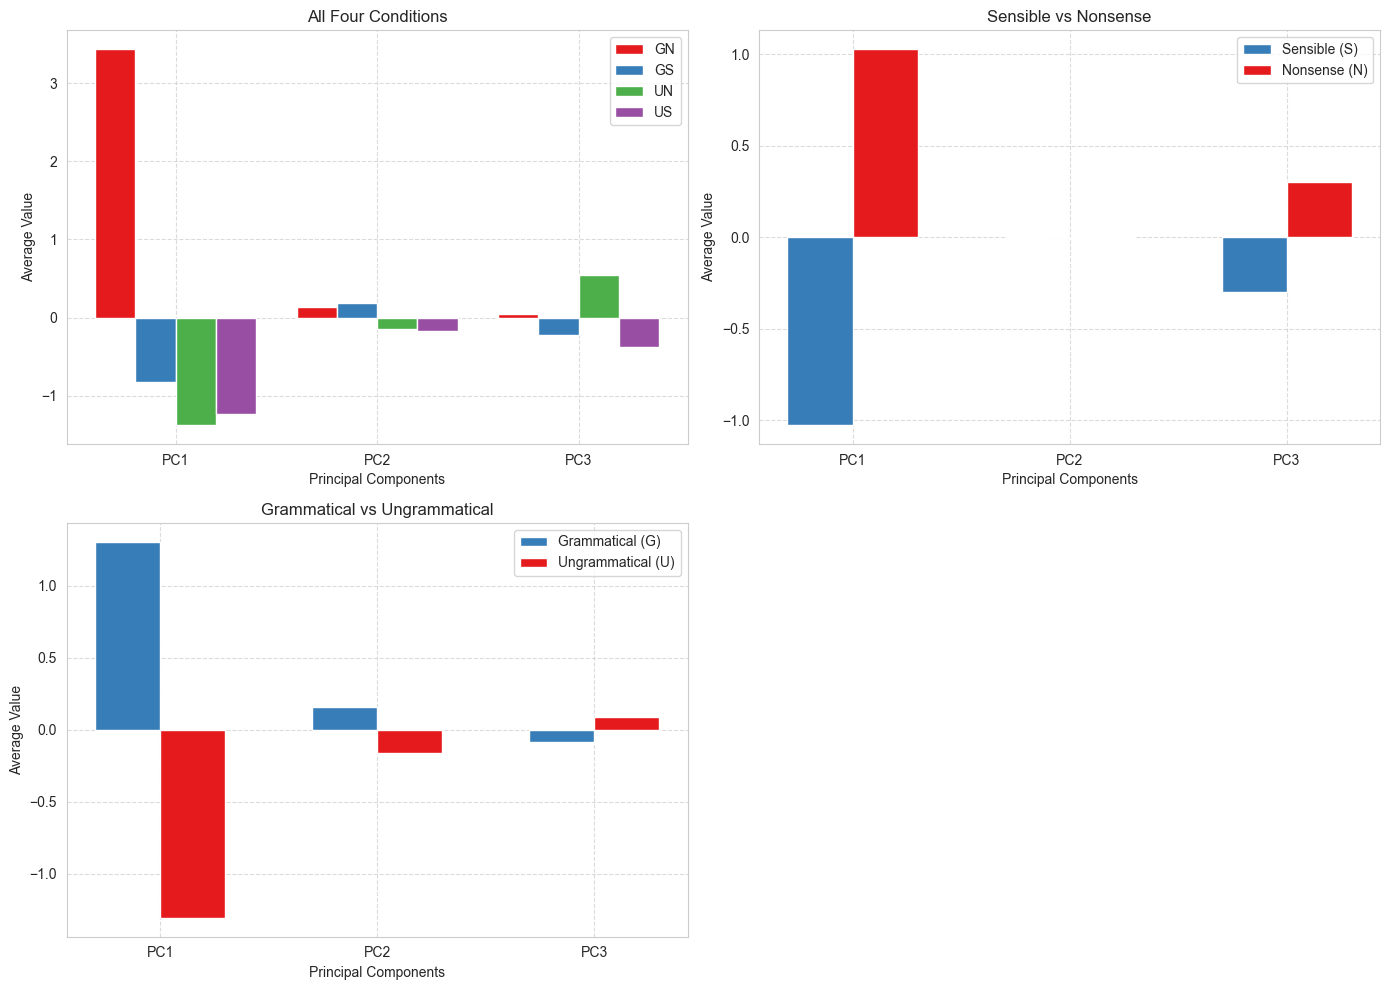


Condition averages (mean values):
GN: PC1=3.4367, PC2=0.1327, PC3=0.0512
GS: PC1=-0.8233, PC2=0.1828, PC3=-0.2265
UN: PC1=-1.3796, PC2=-0.1404, PC3=0.5518
US: PC1=-1.2338, PC2=-0.1751, PC3=-0.3765

Sensible vs Nonsense differences:
PC1: -2.0571, PC2: 0.0077, PC3: -0.6030

Grammatical vs Ungrammatical differences:
PC1: 2.6134, PC2: 0.3154, PC3: -0.1753


In [52]:
def plot_condition_projections(pca_results, y_conditions):
    """
    Plot PCA component projections for different conditions.
    Shows the average value of each component for each condition.
    """
    
    print("\nPlotting condition projections...")
    
    # Get the PCA transformed data
    X_pca = pca_results['data']
    
    # Get unique conditions
    unique_conditions = np.unique(y_conditions)
    
    # Set up the figure for individual conditions
    plt.figure(figsize=(14, 10))
    
    # Define colors for conditions
    cond_colors = {
        'GN': '#e41a1c',  # Grammatical Nonsense - red
        'GS': '#377eb8',  # Grammatical Sensible - blue
        'UN': '#4daf4a',  # Ungrammatical Nonsense - green
        'US': '#984ea3'   # Ungrammatical Sensible - purple
    }
    
    # Calculate means for each condition and component
    condition_means = {}
    for cond in unique_conditions:
        mask = y_conditions == cond
        condition_means[cond] = np.mean(X_pca[mask], axis=0)
    
    # Plot for all four conditions
    plt.subplot(2, 2, 1)
    width = 0.2
    x = np.arange(3)  # Three components
    
    for i, cond in enumerate(unique_conditions):
        plt.bar(x + i*width, condition_means[cond], width, 
                label=cond, color=cond_colors[cond])
    
    plt.xlabel('Principal Components')
    plt.ylabel('Average Value')
    plt.title('All Four Conditions')
    plt.xticks(x + width*1.5, ['PC1', 'PC2', 'PC3'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot for Sensible vs Nonsense
    plt.subplot(2, 2, 2)
    
    # Calculate averages for S and N
    s_mask = (y_conditions == 'GS') | (y_conditions == 'US')
    n_mask = (y_conditions == 'GN') | (y_conditions == 'UN')
    
    s_avg = np.mean(X_pca[s_mask], axis=0)
    n_avg = np.mean(X_pca[n_mask], axis=0)
    
    # Plot bars
    plt.bar(x - 0.15, s_avg, width=0.3, label='Sensible (S)', color='#377eb8')
    plt.bar(x + 0.15, n_avg, width=0.3, label='Nonsense (N)', color='#e41a1c')
    
    plt.xlabel('Principal Components')
    plt.ylabel('Average Value')
    plt.title('Sensible vs Nonsense')
    plt.xticks(x, ['PC1', 'PC2', 'PC3'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot for Grammatical vs Ungrammatical
    plt.subplot(2, 2, 3)
    
    # Calculate averages for G and U
    g_mask = (y_conditions == 'GN') | (y_conditions == 'GS')
    u_mask = (y_conditions == 'UN') | (y_conditions == 'US')
    
    g_avg = np.mean(X_pca[g_mask], axis=0)
    u_avg = np.mean(X_pca[u_mask], axis=0)
    
    # Plot bars
    plt.bar(x - 0.15, g_avg, width=0.3, label='Grammatical (G)', color='#377eb8')
    plt.bar(x + 0.15, u_avg, width=0.3, label='Ungrammatical (U)', color='#e41a1c')
    
    plt.xlabel('Principal Components')
    plt.ylabel('Average Value')
    plt.title('Grammatical vs Ungrammatical')
    plt.xticks(x, ['PC1', 'PC2', 'PC3'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Print some basic stats
    print("\nCondition averages (mean values):")
    for cond in unique_conditions:
        print(f"{cond}: PC1={condition_means[cond][0]:.4f}, PC2={condition_means[cond][1]:.4f}, PC3={condition_means[cond][2]:.4f}")
    
    # Print pairwise comparisons
    print("\nSensible vs Nonsense differences:")
    print(f"PC1: {s_avg[0] - n_avg[0]:.4f}, PC2: {s_avg[1] - n_avg[1]:.4f}, PC3: {s_avg[2] - n_avg[2]:.4f}")
    
    print("\nGrammatical vs Ungrammatical differences:")
    print(f"PC1: {g_avg[0] - u_avg[0]:.4f}, PC2: {g_avg[1] - u_avg[1]:.4f}, PC3: {g_avg[2] - u_avg[2]:.4f}")

# Call the function with our data
if 'pca_results' in locals() and 'y_conditions' in locals():
    plot_condition_projections(pca_results, y_conditions)

    GN (Grammatical Nonsense) has the highest PC1 value (3.4367), indicating it is most strongly associated with the first principal component.
    GS (Grammatical Sensible) and UN (Ungrammatical Nonsense) have similar PC1 values (-0.8233 vs. -1.3796), suggesting they share some common patterns in the first component.
    US (Ungrammatical Sensible) has the lowest PC3 value (-0.3765), indicating it is most negatively associated with the third component.
     

    PC1: Grammatical conditions (GN + GS) average 1.3067, while ungrammatical conditions (UN + US) average -1.3067. The large difference (2.6134) indicates a clear separation along PC1.
    PC2: Grammatical conditions are slightly more positive (0.1598) than ungrammatical conditions (-0.1562), with a difference of 0.3154.
    PC3: Minimal difference (-0.1753), suggesting similar patterns in this component.
     